In [ ]:
#import library
import pandas as pd 
import numpy as np 
import os
from distutils.dir_util import copy_tree, remove_tree
import cv2
import matplotlib.pyplot as plt
import warnings

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow import keras
from random import randint

In [ ]:
#import google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
default_dir = "/content/drive/MyDrive/data/"
root_dir = "./"
test_dir = default_dir + "OriginalDataset/"
train_dir = default_dir + "AugmentedAlzheimerDataset/"
work_dir = root_dir + "data/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    
     
os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['ModerateDemented', 'MildDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

image_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

In [ ]:
train_dataset = image_generator.flow_from_directory(batch_size=6500,
                                                    directory=work_dir,
                                                    target_size=(176, 176),
                                                    shuffle= True)

Found 40384 images belonging to 4 classes.


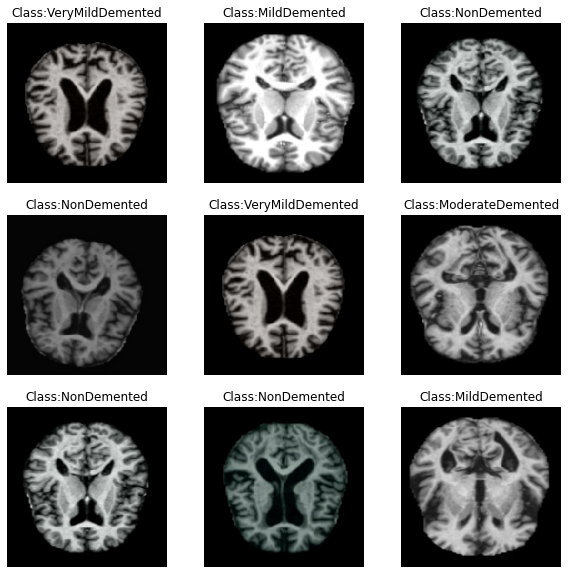

In [ ]:
def show_images(generator,y_pred=None):
  
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a lot of images
    x,y = generator.next()
    
    # show a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0,50)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_dataset)

<BarContainer object of 4 artists>

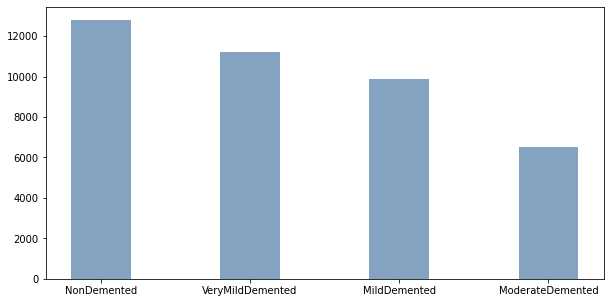

In [ ]:
data = {'NonDemented':      0, 
        'VeryMildDemented': 0, 
        'MildDemented':     0,
        'ModerateDemented': 0}

# visualizing dataset
for cls in os.listdir(work_dir):
    for img in os.listdir(work_dir + '/' + cls):
        data[cls] = data[cls] + 1
        
keys = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(keys, values, color=(0.2, 0.4, 0.6, 0.6), width = 0.4)

In [ ]:
train_data, train_labels = train_dataset.next()

In [ ]:
print(train_data.shape, train_labels.shape)


(6500, 176, 176, 3) (6500, 4)


In [ ]:
#resampling data

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(8524, 176, 176, 3) (8524, 4)


In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:

model = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation = 'relu', input_shape = (176,176,3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.2),
    Dense(4, activation = 'softmax')
])

In [ ]:
#optimizer เป็น adam กำหนดค่าความแม่นยำ (accuracy) เป็น metrics และกำหนดค่าสูญเสีย (loss) เป็น callback
model.compile(optimizer='adam',
loss=tf.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc')])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
#แสดงโมเดล
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 174, 174, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 87, 87, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 32)       0

In [ ]:
#เริ่มต้นกระบวนการเทรน
history = model.fit(train_data, train_labels, 
                  validation_data=(val_data, val_labels), epochs=20)

Epoch 1/20
171/171 [==============================] - 17s 33ms/step - loss: 1.2749 - auc: 0.6602 - val_loss: 1.1512 - val_auc: 0.7586
Epoch 2/20
171/171 [==============================] - 5s 27ms/step - loss: 1.0005 - auc: 0.8189 - val_loss: 0.9299 - val_auc: 0.8415
Epoch 3/20
171/171 [==============================] - 4s 26ms/step - loss: 0.8475 - auc: 0.8680 - val_loss: 0.8231 - val_auc: 0.8853
Epoch 4/20
171/171 [==============================] - 4s 24ms/step - loss: 0.7600 - auc: 0.8935 - val_loss: 0.7703 - val_auc: 0.8881
Epoch 5/20
171/171 [==============================] - 4s 25ms/step - loss: 0.7055 - auc: 0.9082 - val_loss: 0.7228 - val_auc: 0.9065
Epoch 6/20
171/171 [==============================] - 5s 27ms/step - loss: 0.6653 - auc: 0.9194 - val_loss: 0.6954 - val_auc: 0.9108
Epoch 7/20
171/171 [==============================] - 4s 26ms/step - loss: 0.6078 - auc: 0.9335 - val_loss: 0.6399 - val_auc: 0.9272
Epoch 8/20
171/171 [==============================] - 5s 26ms/step -

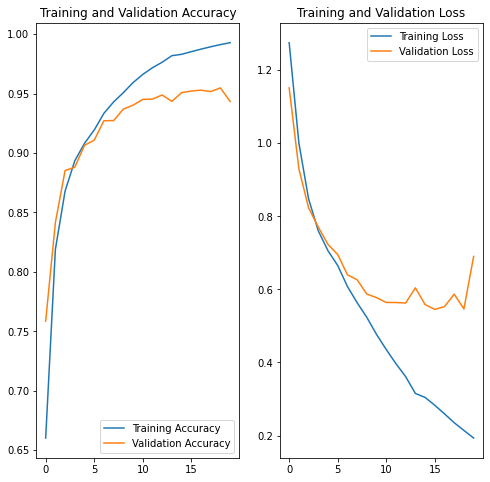

In [ ]:
#สร้างกราฟค่าความแม่นยำ
acc = history.history['auc']
val_acc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

54/54 [==============================] - 1s 12ms/step - loss: 0.5539 - auc: 0.9567
Loss:  0.5539191961288452
Accuracy:  0.9567373991012573


In [ ]:
model.save("model.hdf5")